# Notebook exploration données : metrics

## Imports

In [59]:
import os, json
import pandas as pd
import numpy as np
from azure_blob import download_blob_file
from utilities import string_to_dict
import matplotlib.pyplot as plt
from datetime import datetime

### Data

In [60]:
filename = 'metrics.csv'
path = '../data/'

In [61]:
# téléchargement dans le repertoire 'data' d'un fichiers 'csv' depuis le blob
download_blob_file(file_name=filename, local_path=path)
metrics = os.path.join(path, filename)

metrics.csv already in path ../data/.


In [62]:
# création d'un dataframe à partir du csv de données
metrics_df = pd.read_csv(metrics).sort_values(by='created_at')
metrics_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1164430 entries, 307539 to 1164429
Data columns (total 17 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   id                         1164430 non-null  int64  
 1   status                     1164430 non-null  object 
 2   created_at                 1164430 non-null  object 
 3   cyan_capacity              0 non-null        float64
 4   cyan_remaining             0 non-null        float64
 5   magenta_capacity           0 non-null        float64
 6   magenta_remaining          0 non-null        float64
 7   yellow_capacity            0 non-null        float64
 8   yellow_remaining           0 non-null        float64
 9   black_capacity             0 non-null        float64
 10  black_remaining            0 non-null        float64
 11  machineId                  1164430 non-null  int64  
 12  connected_operators        1164430 non-null  object 
 13  varnish

In [63]:
metrics_df.dropna(axis=1, inplace=True)
metrics_df.drop('machineId', axis=1, inplace=True)
# metrics_df.set_index('id')

In [64]:
metrics_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1164430 entries, 307539 to 1164429
Data columns (total 8 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   id                         1164430 non-null  int64  
 1   status                     1164430 non-null  object 
 2   created_at                 1164430 non-null  object 
 3   connected_operators        1164430 non-null  object 
 4   varnishLevelsTargetvolume  1164430 non-null  float64
 5   varnishLevelsTotalvolume   1164430 non-null  int64  
 6   modules                    1164430 non-null  object 
 7   events                     1164430 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 80.0+ MB


In [65]:
metrics_df.head(3)

,id,status,created_at,connected_operators,varnishLevelsTargetvolume,varnishLevelsTotalvolume,modules,events
307539,4169748,WARNING,2022-04-15 05:55:06.678000,"[{""name"": ""Viktor"", ""level"": ""Operator""}]",36192.322612,100000,"[{""sn"": """", ""name"": ""Print Engine 1"", ""type"": ...",[]
307540,4169749,WARNING,2022-04-15 05:55:06.829000,"[{""name"": ""Viktor"", ""level"": ""Operator""}]",36192.322612,100000,"[{""sn"": """", ""name"": ""Print Engine 1"", ""type"": ...","[{""source"": ""PLC"", ""message"": "" JV-Ti non prêt..."
307537,4169753,WARNING,2022-04-15 05:55:14.494000,"[{""name"": ""Viktor"", ""level"": ""Operator""}]",36192.322612,100000,"[{""sn"": """", ""name"": ""Print Engine 1"", ""type"": ...",[]


## Fonctions

In [66]:
def convert_str_to_list(series):
    return pd.DataFrame(series.apply(lambda x :json.loads(x)), columns=[series.name])

In [67]:
def get_keys(dict):
    return list(k for k in dict.keys() )

In [68]:
def add_key_column(df, col_name, keys, index):
    for key in keys:
        df[col_name+'_'+key+'_'+str(index)] = df[col_name].apply(lambda x: x[index].get(key))
    return df

In [69]:
def check_list_length(list):
    if len(list) :
        print(len(list))

## Dataframes

### Column "connected_operators"

In [70]:
#metrics_df.connected_operators = metrics_df.connected_operators.apply(lambda x :json.loads(x)[0])
connected_operators_df = convert_str_to_list(metrics_df.connected_operators)

In [71]:
# on récupère les clés du dictionnaire dans la première ligne du dataset 'loc.[0]' dans la première case de la liste '[0]'
connected_operators_keys = get_keys(connected_operators_df.connected_operators.loc[0][0])

In [72]:
# on ajoute des colonnes pour chaque clés
for key in connected_operators_keys:
    connected_operators_df = add_key_column(connected_operators_df, 'connected_operators', connected_operators_keys,0)

In [73]:
# on supprime la colonne d'origine
connected_operators_df.drop('connected_operators', axis='columns', inplace=True)

In [74]:
connected_operators_df.rename(columns={
    'connected_operators_name_0': 'operators_name',
    'connected_operators_level_0': 'operators_level'
    }, inplace=True)

In [75]:
connected_operators_df.head(3)

,operators_name,operators_level
307539,Viktor,Operator
307540,Viktor,Operator
307537,Viktor,Operator


### Column "modules"

In [76]:
modules_df = convert_str_to_list(metrics_df.modules)

In [77]:
modules_keys = get_keys(modules_df.modules.loc[0][0])

In [78]:
for key in modules_keys:
    modules_df = add_key_column(modules_df, 'modules', modules_keys,0)
for key in modules_keys:
    modules_df = add_key_column(modules_df, 'modules', modules_keys,1)

In [79]:
modules_df.head(3)

,modules,modules_sn_0,modules_name_0,modules_type_0,modules_counters_0,modules_generation_0,modules_sn_1,modules_name_1,modules_type_1,modules_counters_1,modules_generation_1
307539,"[{'sn': '', 'name': 'Print Engine 1', 'type': ...",,Print Engine 1,Varnish Printer,"[{'name': '3D Varnish Counter', 'value': 17929...",,,iFoil L,iFoil,"[{'name': 'Total Pages Counter', 'value': 2288...",Gen. 2
307540,"[{'sn': '', 'name': 'Print Engine 1', 'type': ...",,Print Engine 1,Varnish Printer,"[{'name': '3D Varnish Counter', 'value': 17929...",,,iFoil L,iFoil,"[{'name': 'Total Pages Counter', 'value': 2288...",Gen. 2
307537,"[{'sn': '', 'name': 'Print Engine 1', 'type': ...",,Print Engine 1,Varnish Printer,"[{'name': '3D Varnish Counter', 'value': 17929...",,,iFoil L,iFoil,"[{'name': 'Total Pages Counter', 'value': 2288...",Gen. 2


In [80]:
modules_df.drop('modules', axis='columns', inplace=True)

In [81]:
modules_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1164430 entries, 307539 to 1164429
Data columns (total 10 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   modules_sn_0          1164430 non-null  object
 1   modules_name_0        1164430 non-null  object
 2   modules_type_0        1164430 non-null  object
 3   modules_counters_0    1164430 non-null  object
 4   modules_generation_0  1164430 non-null  object
 5   modules_sn_1          1164430 non-null  object
 6   modules_name_1        1164430 non-null  object
 7   modules_type_1        1164430 non-null  object
 8   modules_counters_1    1164430 non-null  object
 9   modules_generation_1  1164430 non-null  object
dtypes: object(10)
memory usage: 130.0+ MB


#### Column "modules counters"

In [82]:
modules_counters_keys = get_keys(modules_df.modules_counters_0.loc[0][0])

In [83]:
for key in modules_counters_keys:
    modules_df = add_key_column(modules_df, 'modules_counters_0', modules_counters_keys,0)
for key in modules_counters_keys:
    modules_df = add_key_column(modules_df, 'modules_counters_1', modules_counters_keys,0)

In [84]:
modules_df.drop(['modules_counters_0', 'modules_counters_1'], axis='columns', inplace=True)

In [85]:
modules_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1164430 entries, 307539 to 1164429
Data columns (total 12 columns):
 #   Column                      Non-Null Count    Dtype 
---  ------                      --------------    ----- 
 0   modules_sn_0                1164430 non-null  object
 1   modules_name_0              1164430 non-null  object
 2   modules_type_0              1164430 non-null  object
 3   modules_generation_0        1164430 non-null  object
 4   modules_sn_1                1164430 non-null  object
 5   modules_name_1              1164430 non-null  object
 6   modules_type_1              1164430 non-null  object
 7   modules_generation_1        1164430 non-null  object
 8   modules_counters_0_name_0   1164430 non-null  object
 9   modules_counters_0_value_0  1164430 non-null  int64 
 10  modules_counters_1_name_0   1164430 non-null  object
 11  modules_counters_1_value_0  1164430 non-null  int64 
dtypes: int64(2), object(10)
memory usage: 147.7+ MB


In [86]:
modules_df.dropna(axis='columns', how='any', inplace=True)

In [87]:
for col in modules_df.columns :
    if modules_df[col].nunique() > 1 :
        print(col, 'nombre de valeurs unique : %d' % modules_df[col].nunique())
    else :
        print(col, modules_df[col].unique())

modules_sn_0 ['']
modules_name_0 ['Print Engine 1']
modules_type_0 ['Varnish Printer']
modules_generation_0 ['']
modules_sn_1 ['']
modules_name_1 ['iFoil L']
modules_type_1 ['iFoil']
modules_generation_1 ['Gen. 2']
modules_counters_0_name_0 ['3D Varnish Counter']
modules_counters_0_value_0 nombre de valeurs unique : 294500
modules_counters_1_name_0 ['Total Pages Counter']
modules_counters_1_value_0 nombre de valeurs unique : 65342


In [88]:
columns_to_drop = []
for col in modules_df.columns :
    if modules_df[col].nunique() == 1 :
        if modules_df[col].unique().item() != '':
            columns_to_drop.append(col)
        else :
            modules_df.drop(columns=[col], axis='columns', inplace=True)

In [89]:
modules_df.rename(columns={
    'modules_counters_0_value_0': 'VarnishPrinter_3DVarnishCounter',
    'modules_counters_1_value_0': 'iFoil_TotalPagesCounter'
    }, inplace=True)
modules_df.drop(columns=columns_to_drop, axis='columns', inplace=True)

In [90]:
modules_df.head(3)

,VarnishPrinter_3DVarnishCounter,iFoil_TotalPagesCounter
307539,1792992,22881
307540,1792992,22881
307537,1792992,22881


### Column "events"

In [91]:
events_df = convert_str_to_list(metrics_df.events)

In [92]:
events_keys = []
for i in range(0, len(events_df)) :
    if len(events_df.events.loc[i]) != 0 :
        event_keys = events_df.events.loc[i][0].keys()
        if event_keys not in events_keys :
            events_keys.append(event_keys)

In [93]:
events_keys

[dict_keys(['source', 'message', 'timestamp', 'criticality', 'identification'])]

In [94]:
events_dict = {}
for key in event_keys :
    events_dict[key] = None

In [95]:
events_df['Length'] = events_df.events.map(len)

In [96]:
df = pd.DataFrame(events_df.events.to_list(), dtype=object)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11
0,None,None,None,None,None,None,None,None,None,None,None,None
1,"{'source': 'PLC', 'message': ' JV-Ti non prêt ...",None,None,None,None,None,None,None,None,None,None,None
2,None,None,None,None,None,None,None,None,None,None,None,None
3,None,None,None,None,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None,None,None,None,None


In [97]:
for col in df.columns :
    for i in range(0,len(df.iloc[:,col])):
        if isinstance(df.loc[i][col], type(None)) :
            df.loc[i][col] = events_dict

In [98]:
# renommage des colonnes du dataframe des events
i = 0
col_names = {}
for col in range(df.columns.start, df.columns.stop):
    col_names[col] = 'event_'+str(col)
df.rename(columns=col_names, inplace=True)

In [99]:
df.head(3)

,event_0,event_1,event_2,event_3,event_4,event_5,event_6,event_7,event_8,event_9,event_10,event_11
0,"{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':..."
1,"{'source': 'PLC', 'message': ' JV-Ti non prêt ...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':..."
2,"{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':...","{'source': None, 'message': None, 'timestamp':..."


In [100]:
df1 = pd.DataFrame()
i = 0
for col in df.columns :
    df1[[
        'source_'+str(col),
        'message_'+str(col),
        'timestamp_'+str(col),
        'criticality_'+str(col),
        'identification_'+str(col)
        ]] = pd.DataFrame(df.iloc[:,i].tolist(), index= df.index)
    i += 1

#### Identification

In [101]:
df2 = df1

In [102]:
identification_data = {}
for col in df2.columns :
    if 'identification_' in col :
        identification_data[col] = df2[col].values
identification_data

{'identification_event_0': array([None, '391', None, ..., '330', None, None], dtype=object),
 'identification_event_1': array([None, None, None, ..., None, None, None], dtype=object),
 'identification_event_2': array([None, None, None, ..., None, None, None], dtype=object),
 'identification_event_3': array([None, None, None, ..., None, None, None], dtype=object),
 'identification_event_4': array([None, None, None, ..., None, None, None], dtype=object),
 'identification_event_5': array([None, None, None, ..., None, None, None], dtype=object),
 'identification_event_6': array([None, None, None, ..., None, None, None], dtype=object),
 'identification_event_7': array([None, None, None, ..., None, None, None], dtype=object),
 'identification_event_8': array([None, None, None, ..., None, None, None], dtype=object),
 'identification_event_9': array([None, None, None, ..., None, None, None], dtype=object),
 'identification_event_10': array([None, None, None, ..., None, None, None], dtype=objec

In [103]:
identification_df = pd.DataFrame(identification_data, index=df2.index)

## Fusion dataframes

In [104]:
# fusion des dataframes des colonnes fracionnées
full_df = pd.merge(
            pd.merge(
                pd.merge(metrics_df, connected_operators_df, left_index=True, right_index=True), 
                    modules_df, left_index=True, right_index=True), 
                        df1, left_index=True, right_index=True)
# suppression des colonnes fractionnées
full_df.drop(['connected_operators','modules','events'], axis=1, inplace=True)
# conversion de la colonne "created_at" au format Date
full_df['created_at'] = pd.to_datetime(full_df['created_at'])
# indexation du dataset avec les valeurs "created_at"
full_df.index = full_df['created_at']
# suppression de la colonne "created_at"
del full_df['created_at']
# sauvegarde du dataset en csv
full_df.to_csv('../data/metrics/metrics_df.csv')

In [105]:
full_df

,id,status,varnishLevelsTargetvolume,varnishLevelsTotalvolume,operators_name,operators_level,VarnishPrinter_3DVarnishCounter,iFoil_TotalPagesCounter,source_event_0,message_event_0,...,source_event_10,message_event_10,timestamp_event_10,criticality_event_10,identification_event_10,source_event_11,message_event_11,timestamp_event_11,criticality_event_11,identification_event_11
created_at,,,,,,,,,,,,,,,,,,,,,
2022-04-15 05:55:06.678,4169748,WARNING,36192.322612,100000,Viktor,Operator,1792992,22881,None,None,...,None,None,None,None,None,None,None,None,None,None
2022-04-15 05:55:06.829,4169749,WARNING,36192.322612,100000,Viktor,Operator,1792992,22881,None,None,...,None,None,None,None,None,None,None,None,None,None
2022-04-15 05:55:14.494,4169753,WARNING,36192.322612,100000,Viktor,Operator,1792992,22881,None,None,...,None,None,None,None,None,None,None,None,None,None
2022-04-15 05:55:24.503,4169758,WARNING,36192.322612,100000,Viktor,Operator,1792992,22881,None,None,...,None,None,None,None,None,None,None,None,None,None
2022-04-15 05:55:34.515,4169763,WARNING,36192.322612,100000,Viktor,Operator,1792992,22881,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-12 08:20:57.846,10909300,IDLE,89002.696800,100000,Viktor,Operator,2547041,55386,None,None,...,None,None,None,None,None,None,None,None,None,None
2022-12-12 08:21:08.067,10909304,IDLE,88999.004996,100000,Viktor,Operator,2547042,55387,PLC,En attente,...,None,None,None,None,None,None,None,None,None,None
2022-12-12 08:21:18.076,10909309,IDLE,88999.004996,100000,Viktor,Operator,2547042,55387,None,None,...,None,None,None,None,None,None,None,None,None,None


In [106]:
# dataset temporaire
temp_df = full_df
temp_df.drop([
       'source_event_0', 'message_event_0', 'timestamp_event_0',
       'criticality_event_0', 'identification_event_0', 'source_event_1',
       'message_event_1', 'timestamp_event_1', 'criticality_event_1',
       'identification_event_1', 'source_event_2', 'message_event_2',
       'timestamp_event_2', 'criticality_event_2', 'identification_event_2',
       'source_event_3', 'message_event_3', 'timestamp_event_3',
       'criticality_event_3', 'identification_event_3', 'source_event_4',
       'message_event_4', 'timestamp_event_4', 'criticality_event_4',
       'identification_event_4', 'source_event_5', 'message_event_5',
       'timestamp_event_5', 'criticality_event_5', 'identification_event_5',
       'source_event_6', 'message_event_6', 'timestamp_event_6',
       'criticality_event_6', 'identification_event_6', 'source_event_7',
       'message_event_7', 'timestamp_event_7', 'criticality_event_7',
       'identification_event_7', 'source_event_8', 'message_event_8',
       'timestamp_event_8', 'criticality_event_8', 'identification_event_8',
       'source_event_9', 'message_event_9', 'timestamp_event_9',
       'criticality_event_9', 'identification_event_9', 'source_event_10',
       'message_event_10', 'timestamp_event_10', 'criticality_event_10',
       'identification_event_10', 'source_event_11', 'message_event_11',
       'timestamp_event_11', 'criticality_event_11',
       'identification_event_11'], axis=1, inplace=True)
temp_df.to_csv('../data/metrics/temp_metrics_df.csv')

## Data exploration

In [107]:
def plot_timeseries(dataframe) :
    dataframe.plot(figsize=(15, 6))
    plt.savefig('../data/metrics/metrics_df.png')
    plt.show()

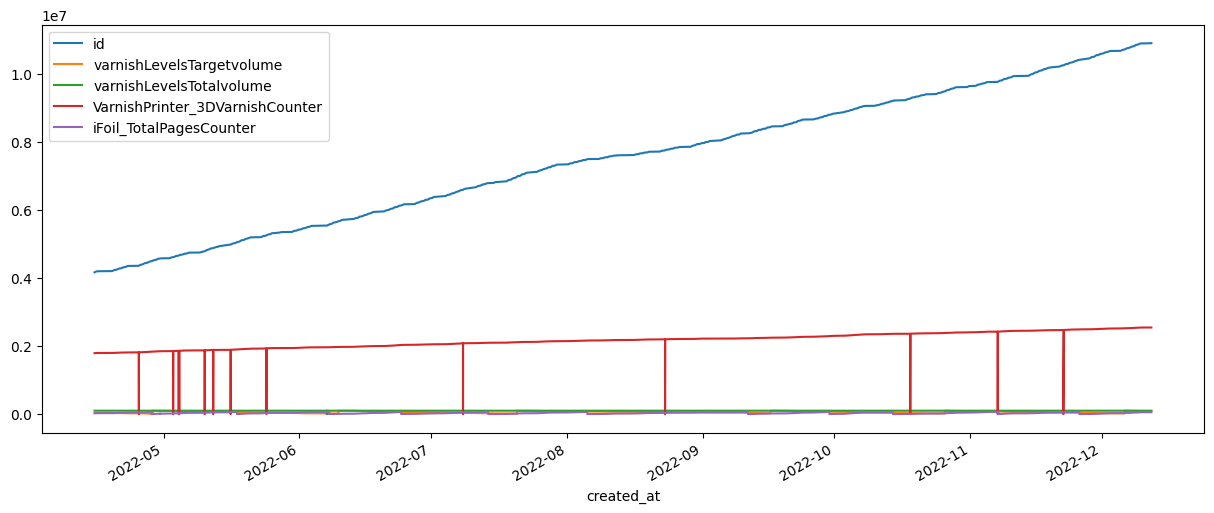

In [108]:
plot_timeseries(temp_df)

In [109]:
# df = metrics_df.loc[:, ['created_at', 'varnishLevelsTargetvolume']]
# # Set the Date as Index
# df.created_at = pd.to_datetime(df.created_at)
# df.index = df['created_at']
# del df['created_at']
# df.plot(figsize=(15, 6))
# plt.show()